<a href="https://colab.research.google.com/github/rainbowisnotmyname/Loan_Prediction/blob/main/Binary_Classfication_Model_Loan_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# นายรัชชานนท์ กิจเจริญ รหัสนักศึกษา 62070266
# นายรุ่ง คนยืน รหัสนักศึกษา 62070267

# import เครื่องมือที่ใช้

In [ ]:
import csv
import urllib.request
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.pyplot import figure
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
%matplotlib inline
from sklearn.metrics import accuracy_score
from sklearn import metrics

# ติดตั้งเครื่องมือสำหรับการดึงข้อมูลจาก Kaggle

In [ ]:
!pip install kaggle

In [ ]:
import json 
    
# python object(dictionary) to be dumped 
dict1 = {"username":"rudymonne",
         "key":"ac01f320810b34c78d463a7ddb2ae376"}
    
# the kaggle api json file where the output must be stored 
out_file = open("kaggle.json", "w") 
    
json.dump(dict1, out_file, indent = 6) 
    
out_file.close() 

In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

# ขั้นตอนการนำเข้าข้อมูลจาก Kaggle

In [ ]:
import kaggle

In [ ]:
from kaggle.api.kaggle_api_extended import KaggleApi

In [ ]:
loan_data = KaggleApi()
loan_data.authenticate()
loan_data.dataset_download_file('puneeshk/lending-loan-club-dataset',
                                file_name='loan.csv')

!unzip loan.csv.zip

Archive:  loan.csv.zip
  inflating: loan.csv                


In [ ]:
def load_data():
  loan_data = pd.read_csv('loan.csv')
  return loan_data

In [ ]:
loan_data = load_data()

In [ ]:
loan_data

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,...,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0,Jan-85,1,NaN,NaN,3,0,13648,83.70%,9,f,0.00,0.00,5863.155187,5833.84,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-11,Charged Off,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0,Apr-99,5,NaN,NaN,3,0,1687,9.40%,4,f,0.00,0.00,1008.710000,1008.71,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,real estate business,606xx,IL,8.72,0,Nov-01,2,NaN,NaN,2,0,2956,98.50%,10,f,0.00,0.00,3005.666844,3005.67,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,Dec-11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/21/11 > to pay for prop...,other,personel,917xx,CA,20.00,0,Feb-96,1,35.0,NaN,10,0,5598,21%,37,f,0.00,0.00,12231.890000,12231.89,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.0,60 months,12.69%,67.79,B,B5,University Medical Group,1 year,RENT,80000.0,Source Verified,Dec-11,Current,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/21/11 > I plan on combi...,other,Personal,972xx,OR,17.94,0,Jan-96,0,38.0,NaN,15,0,27783,53.90%,38,f,524.06,524.06,3513.330000,3513.33,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39712,92187,92174,2500,2500,1075.0,36 months,8.07%,78.42,A,A4,FiSite Research,4 years,MORTGAGE,110000.0,Not Verified,Jul-

# Cleansing & transformation

## 1. Deal with Dupplicates Data and Missing Value

In [ ]:
# drop Row
def clean_data(loan_data):
  loan_data = loan_data.loc[:, loan_data.nunique() != 1] #ตัดคอลัมน์ที่มีค่าเหมือนกันทั้งหมดออกเนื่องจากไม่ส่งผลต่อการทำนาย
  loan_data = loan_data.dropna(how='all',axis=1)
  loan_data = loan_data.drop_duplicates(subset='member_id')
  loan_data = loan_data.dropna(subset=['pub_rec_bankruptcies'])
  loan_data = loan_data.dropna(subset=['revol_util']).reset_index(drop=True)
  return loan_data

loan_data = clean_data(loan_data)

## 2. Select Usable Data and Transformation

In [ ]:
# drop ตัวแปรที่ไม่จำเป็น url desc title emp_title purpose
loan_data = loan_data.drop(['url', 'desc', 'title', 'emp_title', 'purpose'], axis=1)

# drop column id ออกเนื่องจากเป็นค่าเดียวกับ member id จึงเลือกใช้ member id
loan_data = loan_data.drop(columns='id')

# เนื่องจากไม่มีสถานะ Current จะทำให้คอลัมน์ out_prncp, out_prncp_inv ที่เหลือมีค่าเป็น 0 จึงต้องทำการ Drop คอลัมน์ out_prncp, out_prncp_inv
loan_data = loan_data.drop(['out_prncp', 'out_prncp_inv'], axis=1)

# drop column next_pymnt_d เนื่องจากเป็นค่า nan ทั้งหมด
loan_data = loan_data.drop(['next_pymnt_d'], axis=1)

# เนื่องจาก 2 คอลัมน์นี้ยังมีค่า Null อยู่บางส่วน
loan_data = loan_data.drop(columns=['mths_since_last_delinq', 'mths_since_last_record']) 

In [ ]:
def format_dtype(loan_data):
  loan_data['earliest_cr_line'] = pd.to_datetime(loan_data.earliest_cr_line.str.upper(), format='%b-%y', yearfirst=False)
  loan_data['issue_d'] = pd.to_datetime(loan_data.issue_d.str.upper(), format='%b-%y', yearfirst=False)
  return loan_data

loan_data = format_dtype(loan_data)

In [ ]:
# target ของเราคือ loan_status โดยสนใจแค่ Fully Paid และ Charged Off  
loan_data = loan_data.drop(loan_data[loan_data['loan_status'] == 'Current'].index)
# replace value Fully Paid = 1 & Charged Off = 0
loan_data["loan_status"].replace({"Fully Paid": 1, "Charged Off": 0}, inplace=True)

In [ ]:
# แปลง % int_rate ให้เป็น float
loan_data.int_rate = loan_data.int_rate.apply(lambda x: float(x[:-1]))

# แปลง % revol_util ให้เป็น float โดยต้องดรอป na เพราะคอลลัมปนี้มี null 
loan_data.revol_util = loan_data.revol_util.apply(lambda x: float(x[:-1]))

In [ ]:
# replace Source Verified to Verified in column verification_status
loan_data = loan_data.replace({'Source Verified' : 'Verified'})

In [ ]:
loan_data['grade'] = loan_data['grade'].astype('category').cat.codes
loan_data['sub_grade'] = loan_data['sub_grade'].astype('category').cat.codes
loan_data['verification_status'] = loan_data['verification_status'].astype('category').cat.codes
loan_data['term'] = loan_data['term'].astype('category').cat.codes
loan_data['emp_length'] = loan_data['emp_length'].astype('category').cat.codes
loan_data['home_ownership'] = loan_data['home_ownership'].astype('category').cat.codes

In [ ]:
loan_data.nunique()

member_id                  37830
loan_amnt                    859
funded_amnt                 1012
funded_amnt_inv             7704
term                           2
int_rate                     336
installment                14608
grade                          7
sub_grade                     35
emp_length                    12
home_ownership                 4
annual_inc                  5147
verification_status            2
issue_d                       52
loan_status                    2
zip_code                     809
addr_state                    49
dti                         2853
delinq_2yrs                   11
earliest_cr_line             524
inq_last_6mths                 9
open_acc                      38
pub_rec                        5
revol_bal                  21052
revol_util                  1088
total_acc                     82
total_pymnt                35973
total_pymnt_inv            35660
total_rec_prncp             6697
total_rec_int              33381
total_rec_

In [ ]:
# ใช้เช็คว่าขอลัมป์ที่เหลือยุเฉยๆ
def test():
  for col in loan_data.columns:
    print(col)
    print(loan_data[col].value_counts(), end='\n----------------------\n')
test()

member_id
745584     1
1017274    1
902610     1
492244     1
540109     1
          ..
928168     1
1038990    1
903820     1
979595     1
1251331    1
Name: member_id, Length: 37830, dtype: int64
----------------------
loan_amnt
10000    2737
12000    2213
5000     1978
6000     1858
15000    1801
         ... 
4875        1
15150       1
1225        1
12125       1
28750       1
Name: loan_amnt, Length: 859, dtype: int64
----------------------
funded_amnt
10000    2648
12000    2126
5000     1967
6000     1847
15000    1697
         ... 
19475       1
2025        1
17650       1
30100       1
28750       1
Name: funded_amnt, Length: 1012, dtype: int64
----------------------
funded_amnt_inv
5000.000000     1292
10000.000000    1263
6000.000000     1181
12000.000000    1016
8000.000000      885
                ... 
5985.126598        1
24704.493380       1
11198.882400       1
18888.217370       1
24871.582670       1
Name: funded_amnt_inv, Length: 7704, dtype: int64
-----------------

In [ ]:
loan_data['revol_util'].isnull().sum()

0

In [ ]:
loan_data

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,pub_rec_bankruptcies
0,1296599,5000,5000,4975.0,0,10.65,162.87,1,6,1,3,24000.0,1,2011-12-01,1,860xx,AZ,27.65,0,1985-01-01,1,3,0,13648,83.7,9,5863.155187,5833.84,5000.00,863.16,0.00,0.00,0.00,Jan-15,171.62,May-16,0.0
1,1314167,2500,2500,2500.0,1,15.27,59.83,2,13,10,3,30000.0,1,2011-12-01,0,309xx,GA,1.00,0,1999-04-01,5,3,0,1687,9.4,4,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,Apr-13,119.66,Sep-13,0.0
2,1313524,2400,2400,2400.0,0,15.96,84.33,2,14,1,3,12252.0,0,2011-12-01,1,606xx,IL,8.72,0,2001-11-01,2,2,0,2956,98.5,10,3005.666844,3005.67,2400.00,605.67,0.00,0.00,0.00,Jun-14,649.91,May-16,0.0
3,1277178,10000,10000,10000.0,0,13.49,339.31,2,10,1,3,49200.0,1,2011-12-01,1,917xx,CA,20.00,0,1996-02-01,1,10,0,5598,21.0,37,12231.890000,12231.89,10000.00,2214.92,16.97,0.00,0.00,Jan-15,357.48,Apr-16,0.0
5,1311441,5000,5000,5000.0,0,7.90,156.46,0,3,3,3,36000.0,1,2011-12-01,1,852xx,AZ,11.20,0,2004-11-01,3,9,0,7963,28.3,12,5632.210000,5632.21,5000.00,632.21,0.00,0.00,0.00,Jan-15,161.03,Jan-16,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38965,151536,4800,4800,1100.0,0,10.28,155.52,2,10,0,3,35000.0,0,2007-11-01,1,226xx,VA,7.51,0,2000-03-01,0,11,1,5836,68.7,12,5134.085288,1176.56,4800.00,334.09,0.00,0.00,0.00,Aug-08,3891.08,Aug-08,1.0
38966,150893,7000,7000,1000.0,0,10.59,227.82,2,11,3,0,63500.0,0,2007-11-01,1,853xx,AZ,8.50,0,1989-02-01,1,9,1,14930,79.0,21,8174.021910,1167.72,7000.00,1174.02,0.00,0.00,0.00,May-10,1571.29,Apr-16,1.0
38967,132889,9000,9000,700.0,0,12.49,301.04,3,17,8,0,39000.0,0,2007-10-01,0,207xx,MD,5.08,0,1997-08-01,3,9,1,26233,62.9,37,4015.960000,311.64,1496.83,609.26,0.00,1909.87,668.36,May-08,301.05,May-16,1.0
38968,119040,15450,15450,600.0,0,11.22,507.46,2,13,2,0,40000.0,0,2007-08-01,0,201xx,VA,13.50,0,1992-11-01,3,13,1,6513,34.3,29,11652.750000,451.73,8688.59,2659.96,0.00,304.20,3.09,Oct-09,1016.15,Mar-10,1.0


In [ ]:
loan_data.isnull().sum()

member_id                   0
loan_amnt                   0
funded_amnt                 0
funded_amnt_inv             0
term                        0
int_rate                    0
installment                 0
grade                       0
sub_grade                   0
emp_length                  0
home_ownership              0
annual_inc                  0
verification_status         0
issue_d                     0
loan_status                 0
zip_code                    0
addr_state                  0
dti                         0
delinq_2yrs                 0
earliest_cr_line            0
inq_last_6mths              0
open_acc                    0
pub_rec                     0
revol_bal                   0
revol_util                  0
total_acc                   0
total_pymnt                 0
total_pymnt_inv             0
total_rec_prncp             0
total_rec_int               0
total_rec_late_fee          0
recoveries                  0
collection_recovery_fee     0
last_pymnt

# Feature Selection

## Correlation Method

In [ ]:
# def dummy_feature(loan_data):
#   grade_features = pd.get_dummies(loan_data['grade'], drop_first=False)
#   feature_labels = ['grade_' + str(cls_label) for cls_label in grade_features.columns]
#   grade_features.columns = feature_labels
#   verify_features = pd.get_dummies(loan_data['verification_status'], drop_first=False)
  
#   loan_data = pd.concat([loan_data, grade_features, verify_features],axis=1)
#   return loan_data

In [ ]:
# loan_data = dummy_feature(loan_data)

In [ ]:
loan_data['emp_length'].value_counts()

 1     8368
 10    4329
 2     4202
 3     3947
 4     3290
 5     3157
 0     3071
 6     2133
 7     1686
 8     1408
 9     1209
-1     1030
Name: emp_length, dtype: int64

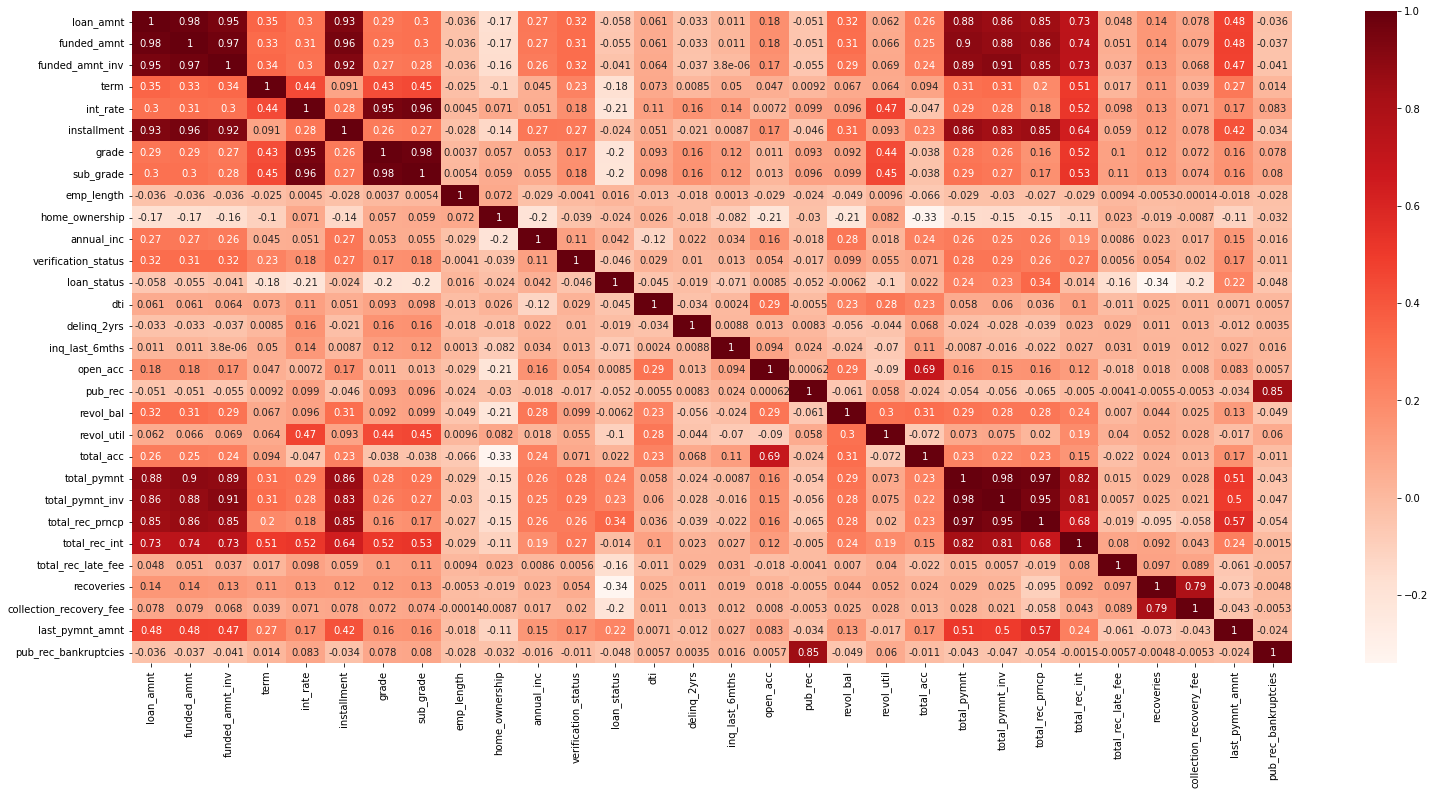

In [ ]:
#Using Pearson Correlation
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html
plt.figure(figsize=(26, 12))
cor = loan_data.drop(columns='member_id').corr(method='pearson') #‘kendall’, ‘spearman’
#plot heat map
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

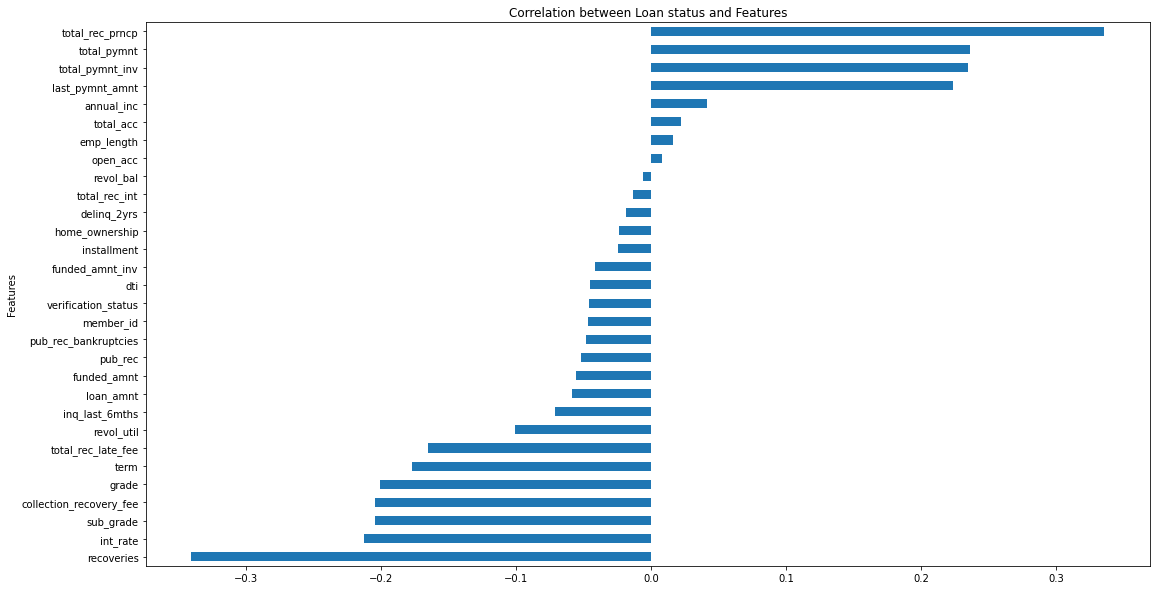

In [ ]:
loan_data.corr()['loan_status'].drop('loan_status').sort_values().plot(
    kind = 'barh',
    title="Correlation between Loan status and Features", 
    ylabel='Correlation', xlabel='Features',
    figsize = (18,10)
)

In [ ]:
# pd.set_option("display.max_rows", None, "display.max_columns", None)
# Convert correlation matrix to 1-D Series and sort
sorted_mat = cor.unstack().sort_values()
sorted_mat

loan_status           recoveries             -0.340185
recoveries            loan_status            -0.340185
total_acc             home_ownership         -0.331369
home_ownership        total_acc              -0.331369
                      revol_bal              -0.214839
                                                ...   
total_rec_int         total_rec_int           1.000000
total_rec_late_fee    total_rec_late_fee      1.000000
recoveries            recoveries              1.000000
delinq_2yrs           delinq_2yrs             1.000000
pub_rec_bankruptcies  pub_rec_bankruptcies    1.000000
Length: 900, dtype: float64

In [ ]:
#Correlation with output variable
cor_target = abs(cor["loan_status"])
#กำนหดให้เลือกตัวแปรที่มีค่า Correlation น้อยกว่า 0.4 บ่งบอกว่าตัวแปรมีความเป็นอิสระกับ Target
features = cor_target[cor_target>0.2]
features #คอลัมน์ที่จะนำไปทำ Train Test Model 

int_rate                   0.212140
grade                      0.200775
sub_grade                  0.204521
loan_status                1.000000
total_pymnt                0.236136
total_pymnt_inv            0.234682
total_rec_prncp            0.335613
recoveries                 0.340185
collection_recovery_fee    0.203849
last_pymnt_amnt            0.223295
Name: loan_status, dtype: float64

In [ ]:
list_features = list(features.index.values) #กำหนดคอลัมน์ที่กำหนดในการสร้างโมเดล

In [ ]:
loan_data[list_features]

,int_rate,grade,sub_grade,loan_status,total_pymnt,total_pymnt_inv,total_rec_prncp,recoveries,collection_recovery_fee,last_pymnt_amnt
0,10.65,1,6,1,5863.155187,5833.84,5000.00,0.00,0.00,171.62
1,15.27,2,13,0,1008.710000,1008.71,456.46,117.08,1.11,119.66
2,15.96,2,14,1,3005.666844,3005.67,2400.00,0.00,0.00,649.91
3,13.49,2,10,1,12231.890000,12231.89,10000.00,0.00,0.00,357.48
5,7.90,0,3,1,5632.210000,5632.21,5000.00,0.00,0.00,161.03
...,...,...,...,...,...,...,...,...,...,...
38965,10.28,2,10,1,5134.085288,1176.56,4800.00,0.00,0.00,3891.08
38966,10.59,2,11,1,8174.021910,1167.72,7000.00,0.00,0.00,1571.29
38967,12.49,3,17,0,4015.960000,311.64,1496.83,1909.87,668.36,301.05
38968,11.22,2,13,0,11652.750000,451.73,8688.59,304.20,3.09,1016.15


# Loan Approval Prediction (การทำนายอนุมัติการปล่อยกู้ ว่าลูกค้ารายนั้นๆจะสามารถกู้ผ่านได้หรือไม่)

# Modeling

## 1. Separate Data into Features (X) and Target (y)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
loan_data_raw = loan_data.drop(["loan_status", "issue_d", "earliest_cr_line", "zip_code",
                                "addr_state", "last_pymnt_d", "last_credit_pull_d"], axis=1)

ข้อมูลที่ไม่ได้ทำ Feature Selection แต่ตัดเฉพาะบางข้อมูลที่ใช้งานไม่ได้ จำพวก วันที่, เขตพื้นที่

In [ ]:
X = loan_data_raw
y = loan_data['loan_status']

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
X_train.shape

(30264, 30)

In [ ]:
X_test.shape

(7566, 30)

ข้อมูลที่ผ่านการ Feature Selection

In [ ]:
X2 = loan_data[list_features].drop(['loan_status'], axis=1)
y2 = loan_data['loan_status']

# Split dataset into training set and test set
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2)

In [ ]:
X_train2.shape

(30264, 9)

In [ ]:
X_test2.shape

(7566, 9)

## Tuning a HyperParameter 


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
#Create a function for Parameter Tuning
def hyper_tuning(model, param, X_train, Y_train):
  model_ = RandomizedSearchCV(model, param_distributions=param, random_state=5, n_jobs=-1, cv=5)
  search = model_.fit(X_train, Y_train)
  return search.best_estimator_

## 2. Train/fit a model

### Random Forest Classification Model

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
def randommodel(X_train, y_train, X_test):
    #Create a Random Forest Classifier using Hyper Function
    clf = hyper_tuning(RandomForestClassifier(),
                    {
                        'n_estimators':[50,100,150,200],
                        'criterion':['gini','entropy'],
                        'max_depth':[1,2,3,None],
                        'bootstrap':[True,False],
                        'class_weight':['balanced','balanced_sumsample'],
                        'max_features':['auto','sqrt','log2'],
                        'warm_start':[True,False]
                    },                 
                    X_train,
                    y_train
                    )

    #Train the model using the training sets y_pred=clf.predict(X_test)
    clf.fit(X_train, y_train)

    y_pred_clf = clf.predict(X_test)
    return clf, y_pred_clf

In [ ]:
clf, y_pred_clf = randommodel(X_train, y_train, X_test)
clf2, y_pred_clf2 = randommodel(X_train2, y_train2, X_test2)

In [ ]:
# Classification report without feature selection
print("Accuracy score:",metrics.accuracy_score(y_test, y_pred_clf))
print(classification_report(y_test, y_pred_clf))

Accuracy score: 0.9962992334126355
              precision    recall  f1-score   support

           0       1.00      0.97      0.99      1106
           1       1.00      1.00      1.00      6460

    accuracy                           1.00      7566
   macro avg       1.00      0.99      0.99      7566
weighted avg       1.00      1.00      1.00      7566



In [ ]:
# Classification report with feature selection
print("Accuracy score:",metrics.accuracy_score(y_test2, y_pred_clf2))
print(classification_report(y_test2, y_pred_clf2))

Accuracy score: 0.9873116574147502
              precision    recall  f1-score   support

           0       0.99      0.92      0.96      1114
           1       0.99      1.00      0.99      6452

    accuracy                           0.99      7566
   macro avg       0.99      0.96      0.97      7566
weighted avg       0.99      0.99      0.99      7566



In [ ]:
#5-fold cross-validation without feature selection
acc_scores_random = cross_val_score(clf, X, y, cv=5, scoring="accuracy")
print(acc_scores_random)
print("Mean cross-validation accuracy = %.4f" % acc_scores_random.mean() )

[0.99854613 0.99709225 0.9973566  0.99709225 0.99339149]
Mean cross-validation accuracy = 0.9967


In [ ]:
#5-fold cross-validation with feature selection
acc_scores_random2 = cross_val_score(clf2, X2, y2, cv=5, scoring="accuracy")
print(acc_scores_random2)
print("Mean cross-validation accuracy = %.4f" % acc_scores_random2.mean() )

[0.99061591 0.99061591 0.99114459 0.98704732 0.9742268 ]
Mean cross-validation accuracy = 0.9867


In [ ]:
def roc(model, name, X_test, y_test):
    probs = model.predict_proba(X_test)[:, 1]

    fpr, tpr, thresholds = metrics.roc_curve(y_test, probs)

    plt.plot(fpr, tpr, label=name)
    plt.plot([0, 1], [0, 1], linestyle='dashed', color='black')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(name + " ROC Curve")
    print ("AUC for {0} = {1:.4f}".format(name, metrics.roc_auc_score(y_test, probs)))

    plt.legend(loc='best')
    plt.show()

AUC for Random forest (without feature selection) = 1.0000


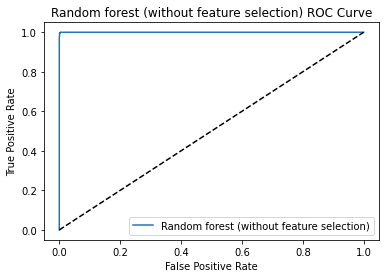

In [ ]:
random_roc_unfeatured = roc(clf, 'Random forest (without feature selection)',X_test, y_test)

AUC for Random forest (with feature selection) = 0.9961


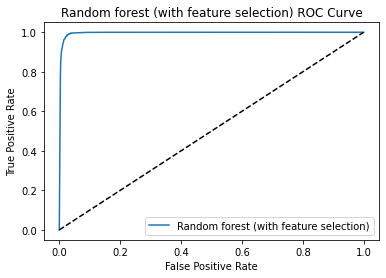

In [ ]:
random_roc_featured = roc(clf2, 'Random forest (with feature selection)',X_test2, y_test2)

### Logistic Regression Model

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
def logismodel(X_train, y_train, X_test):
    LogisticRegr = hyper_tuning(LogisticRegression(),
                    {
                        'penalty':['l1','l2','elastinet','none'],
                        'dual':[True,False],
                        'C':[0.5,1.0,1.5,2.0],
                        'fit_intercept':[True,False],
                        'solver':['newton-cg','lbfgs','liblinear','sag','saga'],
                        'warm_start':[True,False]
                    },
                    X_train,
                    y_train
                    )

    LogisticRegr.fit(X_train, y_train)

    y_pred_logis = LogisticRegr.predict(X_test)
    return LogisticRegr, y_pred_logis

In [ ]:
LogisticRegr, y_pred_logis = logismodel(X_train, y_train, X_test)
LogisticRegr2, y_pred_logis2 = logismodel(X_train2, y_train2, X_test2)

In [ ]:
# Classification report without featured Data
print("Accuracy score:",metrics.accuracy_score(y_test, y_pred_logis))
print(classification_report(y_test, y_pred_logis))

Accuracy score: 0.999735659529474
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1106
           1       1.00      1.00      1.00      6460

    accuracy                           1.00      7566
   macro avg       1.00      1.00      1.00      7566
weighted avg       1.00      1.00      1.00      7566



In [ ]:
# Classification report with feature selection
print("Accuracy score:",metrics.accuracy_score(y_test2, y_pred_logis2))
print(classification_report(y_test2, y_pred_logis2))

Accuracy score: 0.9825535289452815
              precision    recall  f1-score   support

           0       0.99      0.89      0.94      1114
           1       0.98      1.00      0.99      6452

    accuracy                           0.98      7566
   macro avg       0.99      0.94      0.96      7566
weighted avg       0.98      0.98      0.98      7566



In [ ]:
#5-fold cross-validation without feature selection
acc_scores_logis = cross_val_score(LogisticRegr, X, y, cv=5, scoring="accuracy")
print(acc_scores_logis)
print("Mean cross-validation accuracy = %.4f" % acc_scores_logis.mean() )

[0.98691515 0.98744383 0.98295004 0.98215702 0.96206714]
Mean cross-validation accuracy = 0.9803


In [ ]:
#5-fold cross-validation with feature selection
acc_scores_logis2 = cross_val_score(LogisticRegr2, X2, y2, cv=5, scoring="accuracy")
print(acc_scores_logis2)
print("Mean cross-validation accuracy = %.4f" % acc_scores_logis2.mean() )

[0.98691515 0.98744383 0.98295004 0.98215702 0.96206714]
Mean cross-validation accuracy = 0.9803


AUC for Logistic Regression (without feature selection) = 1.0000


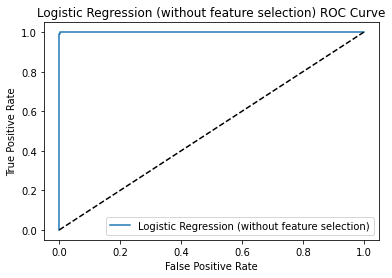

In [ ]:
logis_roc_unfeatured = roc(LogisticRegr, 'Logistic Regression (without feature selection)',X_test, y_test)

AUC for Logistic Regression (with feature selection) = 0.9882


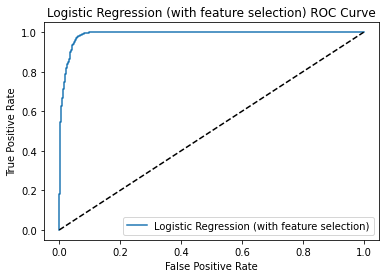

In [ ]:
logis_roc_featured = roc(LogisticRegr2, 'Logistic Regression (with feature selection)',X_test2, y_test2)

### XGBoost Classifier Model

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
def xgboostmodel(X_train, y_train, X_test):
    XGBoost = hyper_tuning(GradientBoostingClassifier(),
                    {
                        'loss':['deviance','exponential'],
                        'learning_rate':[0.1,0.2,0.3],
                        'n_estimators':[90,100,110,120],
                        'max_depth':[1,2,3,4,5],
                        'warm_start':[True,False],
                    },                 
                    X_train,
                    y_train
                    )

    XGBoost.fit(X_train, y_train)

    y_pred_xg = XGBoost.predict(X_test)
    return XGBoost, y_pred_xg

In [ ]:
xgboost, y_pred_xg = xgboostmodel(X_train, y_train, X_test)
xgboost2, y_pred_xg2 = xgboostmodel(X_train2, y_train2, X_test2)

In [ ]:
# Classification report without feature selection
print("Accuracy score:",metrics.accuracy_score(y_test, y_pred_xg))
print(classification_report(y_test, y_pred_xg))

Accuracy score: 0.9977531060005287
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1106
           1       1.00      1.00      1.00      6460

    accuracy                           1.00      7566
   macro avg       1.00      0.99      1.00      7566
weighted avg       1.00      1.00      1.00      7566



In [ ]:
# Classification report with feature selection
print("Accuracy score:",metrics.accuracy_score(y_test2, y_pred_xg2))
print(classification_report(y_test2, y_pred_xg2))

Accuracy score: 0.9885011895321174
              precision    recall  f1-score   support

           0       0.98      0.94      0.96      1114
           1       0.99      1.00      0.99      6452

    accuracy                           0.99      7566
   macro avg       0.99      0.97      0.98      7566
weighted avg       0.99      0.99      0.99      7566



In [ ]:
#5-fold cross-validation without feature selection
acc_scores_xg = cross_val_score(xgboost, X, y, cv=5, scoring="accuracy")
print(acc_scores_xg)
print("Mean cross-validation accuracy = %.4f" % acc_scores_xg.mean())

[0.74253238 0.99788528 0.99788528 0.99828179 0.99471319]
Mean cross-validation accuracy = 0.9463


In [ ]:
#5-fold cross-validation with feature selection
acc_scores_xg2 = cross_val_score(xgboost2, X2, y2, cv=5, scoring="accuracy")
print(acc_scores_xg2)
print("Mean cross-validation accuracy = %.4f" % acc_scores_xg2.mean())

[0.9902194  0.98955855 0.99088025 0.98916204 0.97673804]
Mean cross-validation accuracy = 0.9873


AUC for XGBoost Classifier (without feature selection) = 0.9995


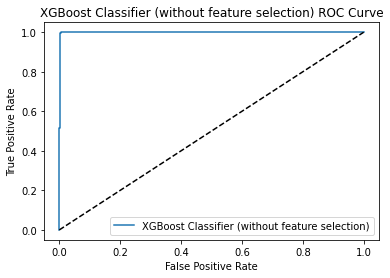

In [ ]:
xgboost_roc_unfeatured = roc(xgboost, 'XGBoost Classifier (without feature selection)',X_test, y_test)

AUC for XGBoost Classifier (with feature selection) = 0.9949


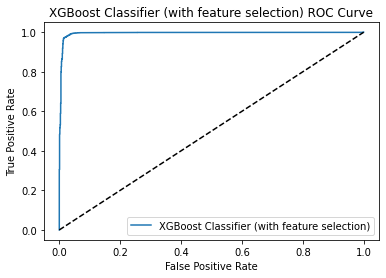

In [ ]:
xgboost_roc_featured = roc(xgboost2, 'XGBoost Classifier (with feature selection)',X_test2, y_test2)

### Decision Trees Model

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
def treemodel(X_train, y_train, X_test):
    clf_dt = hyper_tuning(DecisionTreeClassifier(),
                    {
                        'criterion':['gini','etropy'],
                        'splitter':['best','random'],
                        'max_depth':[2,4,5,6,None],
                        'min_samples_split':[1,2,3,4,2.2,1.9,2.4]
                    },                 
                    X_train,
                    y_train
                    )


    clf_dt.fit(X_train, y_train)

    y_pred_trees = clf_dt.predict(X_test)
    return clf_dt, y_pred_trees

In [ ]:
clf_dt, y_pred_trees = treemodel(X_train, y_train, X_test)
clf_dt2, y_pred_trees2 = treemodel(X_train2, y_train2, X_test2)

In [ ]:
# Classification report without feature selection
print("Accuracy score:",metrics.accuracy_score(y_test, y_pred_trees))
print(classification_report(y_test, y_pred_trees))

Accuracy score: 0.9953740417657944
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1106
           1       1.00      1.00      1.00      6460

    accuracy                           1.00      7566
   macro avg       0.99      0.99      0.99      7566
weighted avg       1.00      1.00      1.00      7566



In [ ]:
# Classification report with feature selection
print("Accuracy score:",metrics.accuracy_score(y_test2, y_pred_trees2))
print(classification_report(y_test2, y_pred_trees2))

Accuracy score: 0.9812318265926513
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      1114
           1       0.99      0.99      0.99      6452

    accuracy                           0.98      7566
   macro avg       0.97      0.96      0.96      7566
weighted avg       0.98      0.98      0.98      7566



In [ ]:
#5-fold cross-validation without feature selection
acc_scores_trees = cross_val_score(clf_dt, X, y, cv=5, scoring="accuracy")
print(acc_scores_trees)
print("Mean cross-validation accuracy = %.4f" % acc_scores_trees.mean() )

[0.16812054 0.99563838 0.99405234 0.99339149 0.96629659]
Mean cross-validation accuracy = 0.8235


In [ ]:
#5-fold cross-validation with feature selection
acc_scores_trees2 = cross_val_score(clf_dt2, X2, y2, cv=5, scoring="accuracy")
print(acc_scores_trees2)
print("Mean cross-validation accuracy = %.4f" % acc_scores_trees2.mean() )

[0.98519693 0.98374306 0.98466825 0.97739889 0.9542691 ]
Mean cross-validation accuracy = 0.9771


AUC for Decision Trees (without feature selection) = 0.9900


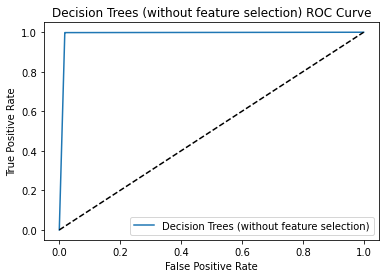

In [ ]:
trees_roc_unfeatured = roc(clf_dt, 'Decision Trees (without feature selection)',X_test, y_test)

AUC for Decision Trees (with feature selection) = 0.9588


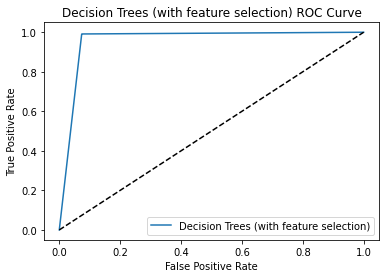

In [ ]:
trees_roc_featured = roc(clf_dt2, 'Decision Trees (with feature selection)',X_test2, y_test2)

### Neural network Classification Model

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
def neuralmodel(X_train, y_train, X_test):
    neural = hyper_tuning(MLPClassifier(),
                    {
                        'activation':['identity','logistic','tanh','relu'],
                        'solver':['lbfgs','sgd','adam'],
                        'learning_rate':['constant','invscaling','adaptive'],
                        'shuffle':[True,False],
                        'warm_start':[True,False]
                    },                 
                    X_train,
                    y_train
                    )

    neural.fit(X_train, y_train)

    y_pred_neural = neural.predict(X_test)
    return neural, y_pred_neural

In [ ]:
neural, y_pred_neural = neuralmodel(X_train, y_train, X_test)
neural2, y_pred_neural2 = neuralmodel(X_train2, y_train2, X_test2)

In [ ]:
# Classification report without feature selection
print("Accuracy score:",metrics.accuracy_score(y_test, y_pred_neural))
print(classification_report(y_test, y_pred_neural))

Accuracy score: 0.9969600845889506
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1106
           1       1.00      1.00      1.00      6460

    accuracy                           1.00      7566
   macro avg       0.99      1.00      0.99      7566
weighted avg       1.00      1.00      1.00      7566



In [ ]:
# Classification report with feature selection
print("Accuracy score:",metrics.accuracy_score(y_test2, y_pred_neural2))
print(classification_report(y_test2, y_pred_neural2))

Accuracy score: 0.9705260375363468
              precision    recall  f1-score   support

           0       0.94      0.86      0.90      1114
           1       0.98      0.99      0.98      6452

    accuracy                           0.97      7566
   macro avg       0.96      0.92      0.94      7566
weighted avg       0.97      0.97      0.97      7566



In [ ]:
#5-fold cross-validation without feature selection
acc_scores_neural = cross_val_score(neural, X, y, cv=5, scoring="accuracy")
print(acc_scores_neural)
print("Mean cross-validation accuracy = %.4f" % acc_scores_neural.mean() )

[0.99418451 0.99418451 0.99537404 0.98955855 0.98070315]
Mean cross-validation accuracy = 0.9908


In [ ]:
#5-fold cross-validation with feature selection
acc_scores_neural2 = cross_val_score(neural2, X2, y2, cv=5, scoring="accuracy")
print(acc_scores_neural2)
print("Mean cross-validation accuracy = %.4f" % acc_scores_neural2.mean() )

[0.97753106 0.98228919 0.97039387 0.96563574 0.94395982]
Mean cross-validation accuracy = 0.9680


AUC for Neural network (without feature selection) = 0.9973


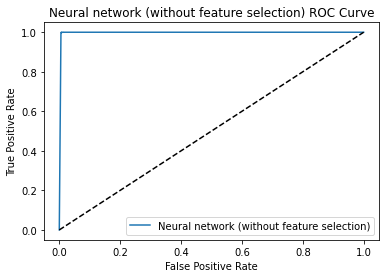

In [ ]:
neural_roc_unfeatured = roc(neural, 'Neural network (without feature selection)',X_test, y_test)

AUC for Neural network (with feature selection) = 0.9767


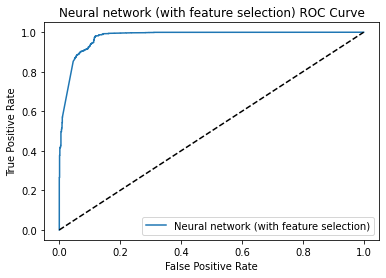

In [ ]:
neural_roc_featured = roc(neural2, 'Neural network (with feature selection)',X_test2, y_test2)

# Evaluate model

In [ ]:
evala = {
    'Model': ['Random Forest', 'Logistic Regression', 'XGBoost', 'Decision Trees', 'Neural Network'],
    'Accuracy (Not Featured)' : [metrics.accuracy_score(y_test, y_pred_clf), metrics.accuracy_score(y_test, y_pred_logis)
    , metrics.accuracy_score(y_test, y_pred_xg), metrics.accuracy_score(y_test, y_pred_trees), metrics.accuracy_score(y_test, y_pred_neural)],
    'Accuracy (Featured)' : [metrics.accuracy_score(y_test2, y_pred_clf2), metrics.accuracy_score(y_test2, y_pred_logis2)
    , metrics.accuracy_score(y_test2, y_pred_xg2), metrics.accuracy_score(y_test2, y_pred_trees2), metrics.accuracy_score(y_test2, y_pred_neural2)],
    'Mean 5-fold cross-validation (Not Featured)' : [acc_scores_random.mean(), acc_scores_logis.mean(), acc_scores_xg.mean()
    , acc_scores_trees.mean(), acc_scores_neural.mean()],
    'Mean 5-fold cross-validation (Featured)' : [acc_scores_random2.mean(), acc_scores_logis2.mean(), acc_scores_xg2.mean()
    , acc_scores_trees2.mean(), acc_scores_neural2.mean()]
}
eval = pd.DataFrame(evala)

In [ ]:
eval

,Model,Accuracy (Not Featured),Accuracy (Featured),Mean 5-fold cross-validation (Not Featured),Mean 5-fold cross-validation (Featured)
0,Random Forest,0.996299,0.987312,0.996696,0.986730
1,Logistic Regression,0.999736,0.982554,0.980307,0.980307
2,XGBoost,0.997753,0.988501,0.946260,0.987312
3,Decision Trees,0.995374,0.981232,0.823500,0.977055
4,Neural Network,0.996960,0.970526,0.990801,0.967962


In [ ]:
import plotly.graph_objects as go
fig = go.Figure(data=[
    go.Bar(name='without feature selection', x=eval.Model, y=eval['Accuracy (Not Featured)'], text=eval['Accuracy (Not Featured)']),
    go.Bar(name='with feature selection', x=eval.Model, y=eval['Accuracy (Featured)'], text=eval['Accuracy (Featured)'])
])
fig.update_traces(opacity=1, texttemplate='%{text:.4f}', textposition='outside')
fig.update_layout(title_text='Accuracy of Feature Selection VS without Feature Selection',
                  height=500, barmode='group', xaxis_title="Accuracy", yaxis_title="Model" )
# Change the bar mode
fig.update_layout(barmode='group')
fig.show()

In [ ]:
fig = go.Figure(data=[
    go.Bar(name='without feature selection', x=eval.Model, y=eval['Mean 5-fold cross-validation (Not Featured)'], text=eval['Mean 5-fold cross-validation (Not Featured)']),
    go.Bar(name='with feature selection', x=eval.Model, y=eval['Mean 5-fold cross-validation (Featured)'], text=eval['Mean 5-fold cross-validation (Featured)'])
])
fig.update_traces(opacity=1, texttemplate='%{text:.4f}', textposition='outside')
fig.update_layout(title_text='Cross Validation of Feature Selection VS without Feature Selection',
                  height=500, barmode='group', xaxis_title="Accuracy", yaxis_title="Model" )
# Change the bar mode
fig.update_layout(barmode='group')
fig.show()

## ROC Curve

In [ ]:
def get_model_roc(models, X_test, names, y_test, title):
  figure(figsize=(12,8))
  for i in range(len(models)):

    model = models[i]
    name = names[i]
    probs = model.predict_proba(X_test)[:, 1]

    fpr, tpr, thresholds = metrics.roc_curve(y_test, probs)

    plt.plot(fpr, tpr, label=name)
    plt.plot([0, 1], [0, 1], linestyle='dashed', color='black')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    print ("AUC for {0} = {1:.4f}".format(name, metrics.roc_auc_score(y_test, probs)))

  plt.legend(loc='best')
  plt.show()

AUC for Random Forest = 1.0000
AUC for Logistic Regression = 1.0000
AUC for XGBoost = 0.9995
AUC for Decision Trees = 0.9900
AUC for Neural Network = 0.9973


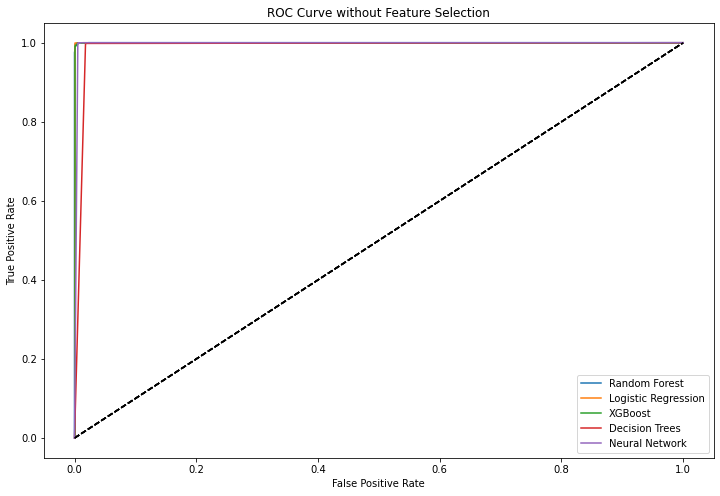

In [ ]:
get_model_roc(
    [clf, LogisticRegr, xgboost, clf_dt, neural],
    X_test,
    ['Random Forest', 'Logistic Regression', 'XGBoost', 'Decision Trees',
     'Neural Network'],
    y_test, 'ROC Curve without Feature Selection'
)

AUC for Random Forest = 0.9961
AUC for Logistic Regression = 0.9882
AUC for XGBoost = 0.9949
AUC for Decision Trees = 0.9588
AUC for Neural Network = 0.9767


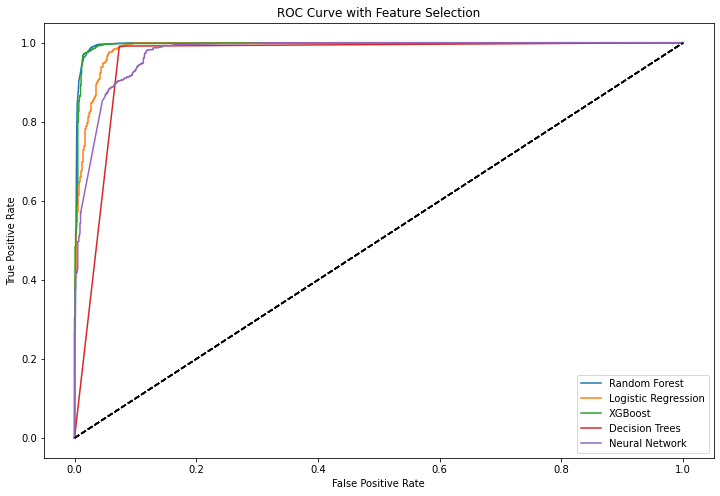

In [ ]:
get_model_roc(
    [clf2, LogisticRegr2, xgboost2, clf_dt2, neural2],
    X_test2,
    ['Random Forest', 'Logistic Regression', 'XGBoost', 'Decision Trees',
     'Neural Network'],
    y_test2, 'ROC Curve with Feature Selection'
)

# Train model for deployment 

In [ ]:
def train_model(df_x, df_y):
    model = RandomForestClassifier(bootstrap=False, class_weight='balanced',
                       criterion='entropy', max_features='sqrt',
                       n_estimators=200)
    model.fit(df_x, df_y)
    return model

In [ ]:
def create_deployable_model(file, loan_data):

    
    df_x = loan_data.drop(['loan_status'], axis=1)
    df_y = loan_data['loan_status']

    model = train_model(df_x, df_y)
    loan_data

    print("Save a trained model to...")
    print(file)
    with open(file,'wb') as f:
        pickle.dump(model, f)

In [ ]:
loan_data_feature = loan_data[list_features]

In [ ]:
create_deployable_model('trained_model/trained_model.plk', loan_data_feature)

Save a trained model to...
trained_model/trained_model.plk


# Save to

In [ ]:
!pip install nbconvert
!jupyter nbconvert --to html /content/Colab_62070266_62070267.ipynb

[NbConvertApp] Converting notebook /content/Colab_62070266_62070267.ipynb to html
[NbConvertApp] Writing 1374085 bytes to /content/Colab_62070266_62070267.html
